## Patches Extractor

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
from time import time

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities_NOMXNET import *
from annotation_utilities import *

/Users/kuiqian/Github/MouseBrainAtlas_dev/src//utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/kuiqian/Github/venv/mousebrainatlas_virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kuiqian/Github/venv/mousebrainatlas_virtualenv/lib/python2.7/site-packages/

Setting environment for an unknown machine. Global root paths must be set as env variables.
{'MD589': 0.46}
Loaded data from saved metadata_cache for MD589


No vtk
No mcubes
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 anchor: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 section_limits: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 cropbox: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
Failed to cache MD585 valid_sections/filenames: MD585
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to

### Variables definition

In [2]:
win_id = 0
stack = 'MD589'

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

# 1: {'patch_size': 224, 'spacing': 56}
patch_loc_root = ROOT_DIR+'/CSHL_patch_locations/'+stack+'/'+stack+'_prep2_gray_win1/'
images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/'
raw_images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'

patch_fn_list = ! ls $patch_loc_root
image_fn_list = ! ls $images_root
raw_image_fn_list = ! ls $raw_images_root

filename_to_section, section_to_filename = DataManager.load_sorted_filenames( stack )

In [3]:
windowing_settings

{0: {'patch_size': 34, 'spacing': 34},
 1: {'patch_size': 224, 'spacing': 56},
 2: {'comment': 'larger margin', 'patch_size': 224, 'spacing': 56},
 3: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 32},
 4: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 128},
 5: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 64},
 6: {'comment': 'twice as large patch', 'patch_size': 448, 'spacing': 64},
 7: {'comment': 'specify size/spacing in terms of microns rather than pixels',
  'patch_size_um': 103.04,
  'spacing_um': 30},
 8: {'comment': 'larger patch', 'patch_size_um': 206.08, 'spacing_um': 30},
 9: {'comment': 'larger patch', 'patch_size_um': 412.16, 'spacing_um': 30},
 10: {'comment': 'larger patch', 'patch_size_um': 824.32, 'spacing_um': 30},
 11: {'comment': 'larger patch', 'patch_size_um': 51.52, 'spacing_um': 30},
 12: {'comment': 'larger patch', 'patch_size_um': 25.76, 'spacing_um': 30}}

### Download essential files

In [5]:
def setup_download_from_s3( rel_fp, recursive=True ):
    s3_fp = 's3://mousebrainatlas-data/'+rel_fp
    local_fp = os.environ['ROOT_DIR']+rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return 
    
    if recursive:
        ! aws s3 cp --recursive $s3_fp $local_fp
    else:
        ! aws s3 cp $s3_fp $local_fp

In [5]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_metadata_cache.json', recursive=False)

ALREADY DOWNLOADED FILE


In [6]:
setup_download_from_s3('CSHL_patch_locations/'+stack+'/'+stack+'_prep2_gray_win1/')

ALREADY DOWNLOADED FILE


In [7]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/')

ALREADY DOWNLOADED FILE


In [31]:
setup_download_from_s3( 'CSHL_data_processed/MD585/MD585_sorted_filenames.txt', recursive=False ) # Change

download: s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_sorted_filenames.txt to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_sorted_filenames.txt


In [ ]:
#setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless/')

In [6]:
local_fp = os.environ['ROOT_DIR']+'CSHL_labelings_v3/MD589/MD589_annotation_contours_05312018031718.hdf'
!aws s3 cp s3://mousebrainatlas-data/annotations_realigned/MD589_annotation_contours_05312018031718_prep2_corr1.hdf $local_fp

download: s3://mousebrainatlas-data/annotations_realigned/MD589_annotation_contours_05312018031718_prep2_corr1.hdf to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD589/MD589_annotation_contours_05312018031718.hdf


In [22]:
stack = 'MD585'

In [59]:
local_fp = os.environ['ROOT_DIR']+'CSHL_labelings_v3/MD585/MD585_annotation_contours_05312018041032.hdf'
! aws s3 cp s3://mousebrainatlas-data/annotations_realigned/MD585_annotation_contours_05312018041032_prep2_corr2.hdf $local_fp

download: s3://mousebrainatlas-data/annotations_realigned/MD585_annotation_contours_05312018041032_prep2_corr2.hdf to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD585/MD585_annotation_contours_05312018041032.hdf


In [24]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142_prep2_thumbnail.tif',recursive=False)

download: s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142_prep2_thumbnail.tif to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142_prep2_thumbnail.tif


### Identify patches based on human annotation
--script identify_patch_class_based_on_labeling_v3_human_annotations.py

In [4]:
fp, latest_timestamp = DataManager.get_annotation_filepath(stack, by_human=True, suffix='contours', \
            timestamp='latest', return_timestamp=True, annotation_rootdir=ANNOTATION_ROOTDIR, download_s3=False)
grid_index_class_lookup_fp = DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, \
                                        win_id=win_id, by_human=True, timestamp=latest_timestamp)
t0 = time.time()
if not os.path.exists(grid_index_class_lookup_fp):
    ! python identify_patch_class_based_on_labeling_v3_human_annotations.py MD589 $win_id
else:
    print('ALREADY IDENTIFY PATCHES')
print(time.time()-t0)
print(grid_index_class_lookup_fp)
grid_index_class_lookup = load_hdf_v2(grid_index_class_lookup_fp)

latest timestamp:  05312018031718
ALREADY IDENTIFY PATCHES
0.000878095626831
/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD589/MD589_annotation_win0_05312018031718_grid_indices_lookup.hdf


In [5]:
# Convert to x, y locations using 'all_locs'
all_locs = grid_parameters_to_sample_locations(win_id=win_id, stack=stack)

In [29]:
print(DataManager.get_image_filepath_v2.__doc__)


        Args:
            version (str): the version string.

        Returns:
            Absolute path of the image file.
        


In [42]:
fn='MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142'

In [43]:
img_fp = os.environ['ROOT_DIR'] +'CSHL_data_processed/MD585/MD585_prep2_thumbnail/'
img_fn = img_fp + fn + '_prep2_thumbnail.tif'

In [60]:
annotation= load_hdf_v2(local_fp)
print(local_fp)

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD585/MD585_annotation_contours_05312018041032.hdf


In [32]:
filename_to_section, section_to_filename = DataManager.load_sorted_filenames( stack )

In [46]:
section=filename_to_section['MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142']
section

272

In [47]:
section_to_filename[section]

'MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142'

In [61]:
annotations_x = []
annotations_y = []

for i in range(len(annotation)):
    section_i = annotation['section'][i]
    if section_i == section:
        vertices = annotation['vertices'][i]
        
        for coordinate in vertices:
            annotations_x.append(coordinate[0]/32)
            annotations_y.append(coordinate[1]/32)

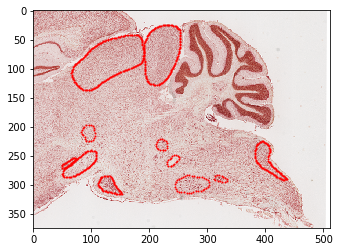

In [62]:
import cv2

img = cv2.imread(img_fn)
plt.imshow( img, cmap='gray' )

plt.scatter(annotations_x, annotations_y, color='r', s=1)

### List valid patches according to structures and sections

In [6]:
all_patch_locations = {}

for structure in all_structures:    
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ]#.tolist()
        all_patch_locations[structure][int(section)] = patch_coors

### Generate valid patches based on annotations directly

In [7]:
local_fp, latest_timestamp = DataManager.get_annotation_filepath(stack, by_human=True, suffix='contours', \
            timestamp='latest', return_timestamp=True, annotation_rootdir=ANNOTATION_ROOTDIR, download_s3=False)
annotation= load_hdf_v2(local_fp)

latest timestamp:  05312018031718


In [31]:
annotation.head()

2276


,class,creator,edits,filename,id,label_position,name,orientation,parent_structure,resolution,section,side,side_manually_assigned,time_created,type,vertices
100157269992733,contour,yuncong,"[{u'username': u'yuncong', u'timestamp': u'091...",MD589-IHC69-2015.07.31-02.07.15_MD589_1_0205,100157269992733,"[7276.284859855292, 7546.993140571727]",VCA,sagittal,[],raw,367,R,False,09152016033619,confirmed,"[[7476.17555322816, 7984.977043818117], [7316...."
100472025966132,contour,yuncong,"[{u'username': u'yuncong', u'timestamp': u'091...",MD589-N51-2015.07.30-19.28.17_MD589_2_0152,100472025966132,"[10644.460680035572, 10933.363273374733]",IO,sagittal,[],raw,260,R,False,09122016211223,confirmed,"[[10135.947729853007, 10933.270657973084], [99..."
10063296125941,contour,yuncong,"[{u'username': u'yuncong', u'timestamp': u'091...",MD589-N55-2015.07.30-19.49.42_MD589_3_0165,10063296125941,"[11608.415904106292, 10622.075455632674]",LRt,sagittal,[],raw,286,R,False,09152016024654,confirmed,"[[11989.668055220041, 11086.806412829588], [11..."
101105413939417,contour,yuncong,"[{u'username': u'yuncong', u'timestamp': u'091...",MD589-N54-2015.07.30-19.44.32_MD589_1_0160,101105413939417,"[11080.859853501861, 10385.125821328125]",LRt,sagittal,[],raw,276,R,False,09152016024654,confirmed,"[[11805.602660507782, 10950.894932558649], [11..."
101214741356495,contour,yuncong,"[{u'username': u'yuncong', u'timestamp': u'053...",MD589-N37-2015.07.30-18.32.51_MD589_1_0109,101214741356495,"[5328.361431529123, 1855.4492753623208]",SC,sagittal,[],raw,202,S,False,05312018021355,intersected,"[[4068.2608695651943, 3084.434782608698], [398..."


In [33]:
prep_id = 2
contours = annotation[(annotation['orientation'] == 'sagittal') & (annotation['resolution'] == 'raw')]
contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'resolution', 'creator'])

In [34]:
contours_grouped = contours.groupby('name')

In [36]:
for struc, cnt_group in contours_grouped:
    polygons = [(contour['section'], contour['vertices']) for contour_id, contour in cnt_group.iterrows()]
type(polygons)

list

In [168]:
section = 103
polygons = [(contour['section'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group('VCP').iterrows() ]
for contour_id, contour in polygons:
    if contour_id==section:
        polygon = contour

In [169]:
margin_um = 200
margin = margin_um / XY_PIXEL_DISTANCE_LOSSLESS

In [170]:
[left, right, up, down] = [int(max(min(polygon[:,0])-margin,0)), 
                           int(min(np.ceil(max(polygon[:,0])+margin),m)),
                           int(max(min(polygon[:,1])-margin,0)), 
                           int(min(np.ceil(max(polygon[:,1])+margin),n))]
print(left, right, up, down)

(7543, 9391, 7733, 9364)


In [171]:
t0 = time.time()
# locations = [(i,j) for i in range(left,right+1) for j in range(up,down+1)]
# locations = np.asarray(locations)
xs, ys = np.meshgrid(np.arange(left, right+1), np.arange(up, down+1),
                     indexing='xy')
locations = np.c_[xs.flat, ys.flat]
print(locations.shape,type(locations))
print(time.time()-t0)
path = Path(polygon)
indices_inside = np.where(path.contains_points(locations))[0]
print(type(indices_inside))
print(time.time()-t0)
len(locations[indices_inside])

((3017568, 2), <type 'numpy.ndarray'>)
0.0572838783264
<type 'numpy.ndarray'>
0.23091006279


444956

444956
2.97899508476
(11936, 15520)
uint8
3.18129706383
(1632, 1849)


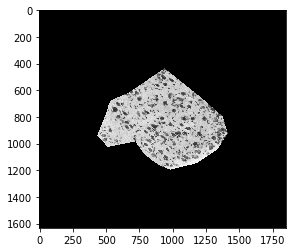

In [172]:
indices_in = locations[indices_inside]
x_raw =indices_in[:,0]-left
y_raw =indices_in[:,1]-up
print(len(indices_in))
t0=time.time()
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
print(time.time()-t0)
m, n = img.shape
print(m,n)
mask = np.zeros((down-up+1, right-left+1))
for i in range(len(indices_in)):
    mask[y_raw[i],x_raw[i]]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
print(time.time()-t0)
patch = img[up:down+1,left:right+1]*mask
print(patch.shape)
#plt.figure( figsize=(50,50) )
plt.imshow( patch, cmap='gray')
#plt.imshow(mask, cmap='gray')

In [176]:
t0 = time.time()
# xs, ys = np.meshgrid(np.arange(left, right+1), np.arange(up, down+1),
#                      indexing='xy')
# locations = np.c_[xs.flat, ys.flat]
# print(locations.shape,type(locations))
# print(time.time()-t0)
surround = Polygon(polygon).buffer(margin, resolution=2)
path = Path(list(surround.exterior.coords))
indices_sur = np.where(path.contains_points(locations))[0]
indices_outside = np.setdiff1d(indices_sur, indices_inside)
print(type(indices_out))
print(time.time()-t0)
len(locations[indices_outside])

<type 'numpy.ndarray'>
0.38019990921


1665626

1665626
uint8
0.70954990387
(1632, 1849)


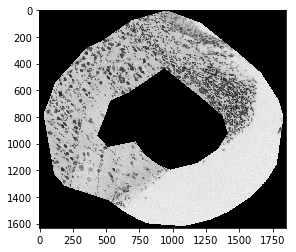

In [177]:
indices_out = locations[indices_outside]
x_raw =indices_out[:,0]-left
y_raw =indices_out[:,1]-up
print(len(indices_out))
t0=time.time()
mask = np.zeros((down-up+1, right-left+1))
for i in range(len(indices_out)):
    mask[y_raw[i],x_raw[i]]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
print(time.time()-t0)
patch = img[up:down+1,left:right+1]*mask
print(patch.shape)
#plt.figure( figsize=(50,50) )
plt.imshow( patch, cmap='gray')

### Save regions to files

In [183]:
# Regions
t0 = time.time()
margin_um = 200
margin = margin_um / XY_PIXEL_DISTANCE_LOSSLESS
! mkdir $ROOT_DIR/CSHL_regions
! mkdir $ROOT_DIR/CSHL_regions/$stack
for structure in all_structures:
    t1 = time.time()
    posi_path = ROOT_DIR+'/CSHL_regions/'+stack+'/'+structure
    nega_path = posi_path+'_surround_200um_noclass'
    if os.path.exists(posi_path):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $posi_path
        ! mkdir $nega_path
    
    polygons = [(contour['section'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(structure).iterrows() ]
    
    for contour_id, contour in polygons:
        section = contour_id
        polygon = contour
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
        m, n = img.shape
        [left, right, up, down] = [int(max(min(polygon[:,0])-margin,0)), 
                                   int(min(np.ceil(max(polygon[:,0])+margin),n-1)),
                                   int(max(min(polygon[:,1])-margin,0)), 
                                   int(min(np.ceil(max(polygon[:,1])+margin),m-1))]
        xs, ys = np.meshgrid(np.arange(left, right+1), np.arange(up, down+1), indexing='xy')
        locations = np.c_[xs.flat, ys.flat]
        
        # Positive regions
        path = Path(polygon)
        indices_inside = np.where(path.contains_points(locations))[0]
        indices_in = locations[indices_inside]
        x_raw =indices_in[:,0]-left
        y_raw =indices_in[:,1]-up
        mask = np.zeros((down-up+1, right-left+1))
        for i in range(len(indices_in)):
            mask[y_raw[i],x_raw[i]]=1
        mask=mask.astype(np.uint8)
        patch = img[up:down+1,left:right+1]*mask
        filename=posi_path+'/'+str(section)+'.tif'
        cv2.imwrite(filename, patch)
        
        # Negative regions
        surround = Polygon(polygon).buffer(margin, resolution=2)
        path = Path(list(surround.exterior.coords))
        indices_sur = np.where(path.contains_points(locations))[0]
        indices_outside = np.setdiff1d(indices_sur, indices_inside)
        indices_out = locations[indices_outside]
        x_raw =indices_out[:,0]-left
        y_raw =indices_out[:,1]-up
        mask = np.zeros((down-up+1, right-left+1))
        for i in range(len(indices_out)):
            mask[y_raw[i],x_raw[i]]=1
        mask=mask.astype(np.uint8)
        patch = img[up:down+1,left:right+1]*mask
        filename=nega_path+'/'+str(section)+'.tif'
        cv2.imwrite(filename, patch)
    print(structure + ' finished in %5.1f seconds' % (time.time() - t1))
print('Finished in %5.1f seconds' % (time.time() - t0))

mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_regions: File exists
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_regions/MD589: File exists
5N ALREADY EXIST
6N ALREADY EXIST
7N ALREADY EXIST
7n ALREADY EXIST
Amb ALREADY EXIST
LC ALREADY EXIST
LRt finished in 356.9 seconds
Pn finished in 614.9 seconds
Tz finished in 211.0 seconds
VLL finished in 348.1 seconds
RMC finished in 235.6 seconds
SNC finished in 303.0 seconds
SNR finished in 972.8 seconds
3N finished in  95.4 seconds
4N finished in  32.6 seconds
Sp5I finished in 491.3 seconds
Sp5O finished in 657.8 seconds
Sp5C finished in 1169.6 seconds
PBG finished in  82.0 seconds
10N finished in 174.2 seconds
VCA finished in 362.8 seconds
VCP finished in 229.5 seconds
DC finished in 491.2 seconds
AP finished in  54.6 seconds
12N finished in 216.3 seconds
RtTg finished in  77.8 seconds
SC finished in 3062.8 seconds
IC finished in 2004.8 seconds


In [7]:
s3_fp = 's3://mousebrainatlas-data/'+'CSHL_regions/'+stack
local_fp = os.environ['ROOT_DIR']+'/CSHL_regions/'+stack
! aws s3 cp --recursive $local_fp $s3_fp

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/.DS_Store to s3://mousebrainatlas-data/CSHL_regions/MD589/.DS_Store
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N/209.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N/209.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N/211.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N/211.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N/200.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N/200.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N/212.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N/212.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N/201.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N/201.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N/214.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N/214.tif
upl

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N_surround_200um_noclass/215.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N_surround_200um_noclass/215.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N_surround_200um_noclass/217.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N_surround_200um_noclass/217.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N_surround_200um_noclass/216.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N_surround_200um_noclass/216.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N_surround_200um_noclass/218.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N_surround_200um_noclass/218.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/10N_surround_200um_noclass/219.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/10N_surround_200um_noclass/219.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N/220.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N/220.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N/228.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N/228.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N/226.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N/226.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N/230.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N/230.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N/227.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N/227.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N/229.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N/229.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N/222.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N/222.tif

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N_surround_200um_noclass/236.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N_surround_200um_noclass/236.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N_surround_200um_noclass/232.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N_surround_200um_noclass/232.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N_surround_200um_noclass/219.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N_surround_200um_noclass/219.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N_surround_200um_noclass/233.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N_surround_200um_noclass/233.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/12N_surround_200um_noclass/234.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/12N_surround_200um_noclass/234.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/3N_surround_200um_noclass/223.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/3N_surround_200um_noclass/223.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/3N_surround_200um_noclass/213.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/3N_surround_200um_noclass/213.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/3N_surround_200um_noclass/228.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/3N_surround_200um_noclass/228.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/3N_surround_200um_noclass/219.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/3N_surround_200um_noclass/219.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/3N_surround_200um_noclass/230.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/3N_surround_200um_noclass/230.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/5N_surround_200um_noclass/292.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/5N_surround_200um_noclass/292.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/5N_surround_200um_noclass/291.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/5N_surround_200um_noclass/291.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/5N_surround_200um_noclass/293.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/5N_surround_200um_noclass/293.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/5N_surround_200um_noclass/290.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/5N_surround_200um_noclass/290.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/5N_surround_200um_noclass/296.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/5N_surround_200um_noclass/296.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N/170.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N/170.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N/169.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N/169.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N/173.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N/173.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N/174.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N/174.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N/168.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N/168.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N/175.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N/175.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N/178.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N/178.tif
upload: ../..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/179.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/179.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/187.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/187.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/189.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/189.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/191.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/191.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/184.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/184.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/302.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/302.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/307.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/307.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/306.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/306.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/308.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/308.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/7N_surround_200um_noclass/310.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/7N_surround_200um_noclass/310.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/AP_surround_200um_noclass/229.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/AP_surround_200um_noclass/229.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Amb/296.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Amb/296.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Amb/297.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Amb/297.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Amb/299.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Amb/299.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Amb_surround_200um_noclass/164.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Amb_surround_200um_noclass/164.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Amb_surround_200um_noclass/167.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Amb_surround_200um_noclass/167.tif
upload

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/144.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/144.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/143.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/143.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/145.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/145.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/146.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/146.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/148.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/148.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/149.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/149.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/150.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/150.tif
upload: ../..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/343.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/343.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/345.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/345.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/350.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/350.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/349.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/349.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/341.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/341.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/347.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/347.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC/348.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC/348.tif
upload: ../..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/140.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/140.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/143.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/143.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/145.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/145.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/146.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/146.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/144.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/144.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/328.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/328.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/327.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/327.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/316.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/316.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/326.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/326.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/DC_surround_200um_noclass/331.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/DC_surround_200um_noclass/331.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/139.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/139.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/143.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/143.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/145.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/145.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/144.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/144.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/147.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/147.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/148.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/148.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/146.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/146.tif
upload: ../..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/250.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/250.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/259.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/259.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/257.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/257.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/260.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/260.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/264.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/264.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/263.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/263.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC/258.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC/258.tif
upload: ../..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/126.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/126.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/123.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/123.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/128.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/128.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/125.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/125.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/130.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/130.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/213.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/213.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/217.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/217.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/215.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/215.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/216.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/216.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/219.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/219.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/261.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/261.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/256.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/256.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/254.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/254.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/258.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/258.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/251.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/251.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/302.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/302.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/305.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/305.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/308.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/308.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/307.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/307.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/IC_surround_200um_noclass/310.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/IC_surround_200um_noclass/310.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/267.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LC_surround_200um_noclass/267.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/270.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LC_surround_200um_noclass/270.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/181.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LC_surround_200um_noclass/181.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/271.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LC_surround_200um_noclass/271.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LC_surround_200um_noclass/268.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LC_surround_200um_noclass/268.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt/184.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt/184.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt/273.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt/273.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt/276.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt/276.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt/275.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt/275.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt/274.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt/274.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt/278.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt/278.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt/277.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt/277.tif

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/179.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/179.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/175.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/175.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/173.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/173.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/181.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/181.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/159.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/159.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/302.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/302.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/281.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/281.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/293.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/293.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/301.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/301.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/LRt_surround_200um_noclass/298.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/LRt_surround_200um_noclass/298.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/PBG_surround_200um_noclass/135.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/PBG_surround_200um_noclass/135.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/PBG_surround_200um_noclass/134.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/PBG_surround_200um_noclass/134.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/PBG_surround_200um_noclass/133.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/PBG_surround_200um_noclass/133.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/PBG_surround_200um_noclass/130.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/PBG_surround_200um_noclass/130.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/PBG_surround_200um_noclass/129.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/PBG_surround_200um_noclass/129.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn/291.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn/291.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn/290.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn/290.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn/286.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn/286.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn/295.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn/295.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn/293.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn/293.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn/294.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn/294.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/177.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/P

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/222.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/222.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/215.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/215.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/220.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/220.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/224.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/224.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/180.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/180.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/284.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/284.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/280.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/280.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/285.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/285.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/282.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/282.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Pn_surround_200um_noclass/281.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Pn_surround_200um_noclass/281.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RMC_surround_200um_noclass/239.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RMC_surround_200um_noclass/239.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RMC_surround_200um_noclass/242.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RMC_surround_200um_noclass/242.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RMC_surround_200um_noclass/247.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RMC_surround_200um_noclass/247.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RMC_surround_200um_noclass/244.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RMC_surround_200um_noclass/244.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RMC_surround_200um_noclass/246.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RMC_surround_200um_noclass/246.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RtTg_surround_200um_noclass/223.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RtTg_surround_200um_noclass/223.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RtTg_surround_200um_noclass/240.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RtTg_surround_200um_noclass/240.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RtTg_surround_200um_noclass/225.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RtTg_surround_200um_noclass/225.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RtTg_surround_200um_noclass/260.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RtTg_surround_200um_noclass/260.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/RtTg_surround_200um_noclass/250.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/RtTg_surround_200um_noclass/250.tif
upload: ../../../../BstemAtlasDataBackup/ucsd

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC/230.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC/230.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC/231.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC/231.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC/234.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC/234.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC/236.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC/236.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC/233.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC/233.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC/239.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC/239.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC/235.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC/235.tif
upload: ../..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/156.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/156.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/157.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/157.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/158.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/158.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/161.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/161.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/155.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/155.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/199.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/199.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/192.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/192.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/196.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/196.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/205.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/205.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/201.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/201.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/245.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/245.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/242.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/242.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/230.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/230.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/240.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/240.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/246.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/246.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/288.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/288.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/285.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/285.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/292.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/292.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/290.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/290.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SC_surround_200um_noclass/291.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SC_surround_200um_noclass/291.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/173.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/173.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/172.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/172.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/165.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/165.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/175.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/175.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/174.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/174.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/176.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/176.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/177.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/177.tif

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC/312.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC/312.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/146.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/146.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/145.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/145.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/148.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/148.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/151.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/151.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/149

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/275.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/275.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/190.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/190.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/278.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/278.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/277.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/277.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNC_surround_200um_noclass/276.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNC_surround_200um_noclass/276.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR/174.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR/174.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR/264.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR/264.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR/190.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR/190.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR/186.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR/186.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR/265.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR/265.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR/267.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR/267.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR/266.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR/266.tif

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/165.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/165.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/170.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/170.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/171.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/171.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/173.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/173.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/168.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/168.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/286.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/286.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/285.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/285.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/291.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/291.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/284.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/284.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/SNR_surround_200um_noclass/274.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/SNR_surround_200um_noclass/274.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/130.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/130.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/129.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/129.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/131.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/131.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/133.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/133.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/134.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/134.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/135.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/135.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/137.tif to s3://mousebrainatlas-data/CSHL_regions/MD58

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/302.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/302.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/301.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/301.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/293.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/293.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/297.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/297.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/298.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/298.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/304.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/304.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/299.tif to s3://mousebrainatlas-data/CSHL_regions/MD58

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/146.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/146.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/148.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/148.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/152.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/152.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/153.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/153.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/156.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/156.tif
upload: ../../../../BstemAtlasDataBackup/ucsd

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C/307.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C/307.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/195.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/195.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/194.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/194.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/197.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/197.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_noclass/256.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5C_surround_200um_noclass/256.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5C_surround_200um_

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I/126.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I/126.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I/132.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I/132.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I/130.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I/130.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I/131.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I/131.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I/137.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I/137.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I/136.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I/136.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I/141.tif to s3://mousebrainatlas-data/CSHL_regions/MD58

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I_surround_200um_noclass/116.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I_surround_200um_noclass/116.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I_surround_200um_noclass/310.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I_surround_200um_noclass/310.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I_surround_200um_noclass/311.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I_surround_200um_noclass/311.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I_surround_200um_noclass/309.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I_surround_200um_noclass/309.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5I_surround_200um_noclass/307.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5I_surround_200um_noclass/307.tif
upload: ../../../../BstemAtlasDataBackup/ucsd

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/119.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/119.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O/322.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O/322.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/123.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/123.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/124.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/124.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/125.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/125.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/138.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/138.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/317.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/317.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/315.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/315.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/319.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/319.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Sp5O_surround_200um_noclass/321.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Sp5O_surround_200um_noclass/321.tif
upload: ../../../../BstemAtlasDataBackup/ucsd

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz/254.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz/254.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz/256.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz/256.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz/255.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz/255.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz/259.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz/259.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz/258.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz/258.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz/261.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz/261.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz/262.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz/262.tif
upload: ../..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA/339.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA/339.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA/121.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA/121.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/Tz_surround_200um_noclass/222.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/Tz_surround_200um_noclass/222.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA/344.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA/344.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA/346.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA/346.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA/348.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA/348.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA/345.tif to s3://mousebr

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA_surround_200um_noclass/96.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA_surround_200um_noclass/96.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA_surround_200um_noclass/98.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA_surround_200um_noclass/98.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCP/104.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCP/104.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCP/103.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCP/103.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCA_surround_200um_noclass/97.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCA_surround_200um_noclass/97.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCP/105.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCP/105.tif
upload: ..

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCP_surround_200um_noclass/355.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCP_surround_200um_noclass/355.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VLL/131.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VLL/131.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCP_surround_200um_noclass/357.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCP_surround_200um_noclass/357.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCP_surround_200um_noclass/354.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCP_surround_200um_noclass/354.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VCP_surround_200um_noclass/359.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VCP_surround_200um_noclass/359.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VLL/132.tif to s3://mousebrain

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VLL_surround_200um_noclass/164.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VLL_surround_200um_noclass/164.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VLL_surround_200um_noclass/163.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VLL_surround_200um_noclass/163.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VLL_surround_200um_noclass/168.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VLL_surround_200um_noclass/168.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VLL_surround_200um_noclass/157.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VLL_surround_200um_noclass/157.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_regions/MD589/VLL_surround_200um_noclass/160.tif to s3://mousebrainatlas-data/CSHL_regions/MD589/VLL_surround_200um_noclass/160.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSH

### Patch examples display

125
Number of Positive Patches: 541


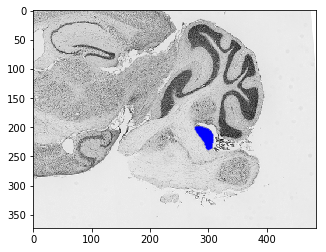

In [55]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
x_offset = 0 #-50
y_offset = 0 #-11
structure = 'DC'
section = all_patch_locations[structure].keys()[20]
print(section)
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Positive Patches:',len(valid_patch_indices)

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (float(x)) )
    y_raw.append( (float(y)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')

plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

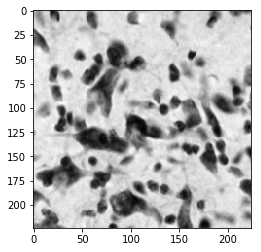

In [8]:

img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
index = 50
x = int( float( all_patch_locations[structure][section][index][0] ) ) 
y = int( float( all_patch_locations[structure][section][index][1] ) ) 

patch = img[y:y+224,x:x+224]


plt.imshow( patch, cmap='gray')

125
Number of Positive Patches: 541
(8891, 9775, 6375, 7599)
(8891, 9775, 6375, 7599)
uint8
(541, 541)
uint8
(1259, 919)


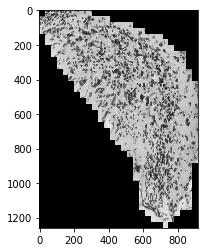

In [30]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
offset = 34
structure = 'DC'
section = all_patch_locations[structure].keys()[20]
print(section)
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Positive Patches:',len(valid_patch_indices)

[left, right, up, down] = [int(min(all_patch_locations[structure][section][:,0])), 
                           int(max(all_patch_locations[structure][section][:,0])),
                           int(min(all_patch_locations[structure][section][:,1])), 
                           int(max(all_patch_locations[structure][section][:,1]))]

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (int(x-left)) )
    y_raw.append( (int(y-up)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )

print(left, right, up, down)
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
print(img.dtype)
mask = np.zeros((down-up+1+offset, right-left+1+offset))
print(len(x_raw),len(y_raw))
for i in range(len(all_locs[valid_patch_indices])):
    mask[y_raw[i]:y_raw[i]+offset,x_raw[i]:x_raw[i]+offset]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
patch = img[up:down+1+offset,left:right+1+offset]*mask#[0:down-up+1,0:right-left+1]
print(patch.shape)
#plt.figure( figsize=(50,50) )
plt.imshow( patch, cmap='gray')
#plt.imshow(mask, cmap='gray')

#plt.scatter(x_raw, y_raw, s=1, c='blue', alpha=.5)

### Save patches to files

In [32]:
# Regions
offset = 34
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        [left, right, up, down] = [int(min(all_patch_locations[structure][section][:,0])), 
                                   int(max(all_patch_locations[structure][section][:,0])),
                                   int(min(all_patch_locations[structure][section][:,1])), 
                                   int(max(all_patch_locations[structure][section][:,1]))]
        mask = np.zeros((down-up+1+offset, right-left+1+offset))
        for x, y in all_patch_locations[structure][section]:
            x = int( x-left ) 
            y = int( y-up ) 
            mask[y:y+offset,x:x+offset]=1
        mask=mask.astype(np.uint8)
        patch = img[up:down+1+offset,left:right+1+offset]*mask
        filename=savepath+'/'+str(section)+'.tif'
        cv2.imwrite(filename, patch)


mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_patches: File exists
7N ALREADY EXIST


In [82]:
# Patches generated by sliding windows
x_offset = 0 #-1600
y_offset = 0 #-352
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        for index in range(len(all_patch_locations[structure][section])):
            x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset
            y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset
            patch = img[y:y+224,x:x+224]
            filename=savepath+'/'+str(section)+'_'+str(index)+'.tif'
            cv2.imwrite(filename, patch)


mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_patches: File exists
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_patches/MD589: File exists
Tz ALREADY EXIST
VCA ALREADY EXIST
7n ALREADY EXIST
DC ALREADY EXIST
5N ALREADY EXIST
3N ALREADY EXIST
Pn ALREADY EXIST
10N ALREADY EXIST
LC ALREADY EXIST
7N ALREADY EXIST
Amb ALREADY EXIST
12N ALREADY EXIST
RMC ALREADY EXIST
Sp5O ALREADY EXIST
Sp5I ALREADY EXIST
Sp5C ALREADY EXIST
VCP ALREADY EXIST
AP ALREADY EXIST
PBG ALREADY EXIST
LRt ALREADY EXIST
IC ALREADY EXIST
VLL ALREADY EXIST
4N ALREADY EXIST
SNC ALREADY EXIST
6N ALREADY EXIST
SNR ALREADY EXIST
SC ALREADY EXIST
RtTg ALREADY EXIST


## Negative patches

In [33]:
all_patch_locations = {}

for structure in all_structures: 
    structure=structure+'_surround_200um_noclass'
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ]#.tolist()
        all_patch_locations[structure][int(section)] = patch_coors

In [48]:
# Regions
offset = 34
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        [left, right, up, down] = [int(min(all_patch_locations[structure][section][:,0])), 
                                   int(max(all_patch_locations[structure][section][:,0])),
                                   int(min(all_patch_locations[structure][section][:,1])), 
                                   int(max(all_patch_locations[structure][section][:,1]))]
        mask = np.zeros((down-up+1+offset, right-left+1+offset))
        for x, y in all_patch_locations[structure][section]:
            x = int( x-left ) 
            y = int( y-up ) 
            mask[y:y+offset,x:x+offset]=1
        mask=mask.astype(np.uint8)
        if img.shape[0]>=down+1+offset and img.shape[1]>=right+1+offset:
            patch = img[up:down+1+offset,left:right+1+offset]*mask
        else:
            xmax = min(img.shape[1],right+1+offset)
            ymax = min(img.shape[0],down+1+offset)
            patch = img[up:ymax,left:xmax]*mask[:ymax-up,:xmax-left]
        filename=savepath+'/'+str(section)+'.tif'
        cv2.imwrite(filename, patch)


mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_patches: File exists
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_patches/MD589: File exists
6N_surround_200um_noclass ALREADY EXIST
5N_surround_200um_noclass ALREADY EXIST
3N_surround_200um_noclass ALREADY EXIST
7n_surround_200um_noclass ALREADY EXIST
SC_surround_200um_noclass ALREADY EXIST
DC_surround_200um_noclass ALREADY EXIST
4N_surround_200um_noclass ALREADY EXIST
LRt_surround_200um_noclass ALREADY EXIST
IC_surround_200um_noclass ALREADY EXIST
SNR_surround_200um_noclass ALREADY EXIST
VLL_surround_200um_noclass ALREADY EXIST
Amb_surround_200um_noclass ALREADY EXIST
Sp5I_surround_200um_noclass ALREADY EXIST
RMC_surround_200um_noclass ALREADY EXIST
VCP_surround_200um_noclass ALREADY EXIST
AP_surround_200um_noclass ALREADY EXIST
12N_surround_200um_noclass ALREADY EXIST
VCA_surround_200um_noclass ALREADY EXIST
PBG_surround_200um_noclass ALREADY EXIST
Tz_surround_200um_noclass ALREADY EXIST
Sp5O_surround_200um_n

In [47]:
print(left, right,up,down)
np.zeros((down-up+1+offset, right-left+1+offset)).shape
print(down-up+1+offset,right-left+1+offset)
img[up:down+1+offset,left:right+1+offset].shape
print(img.shape[1],right+1+offset)
mask[:2,:2]
structure

(12971, 15487, 8993, 11203)
(2245, 2551)
(15520, 15522)


'Sp5C_surround_200um_noclass'

Number of Negative Patches: 1788


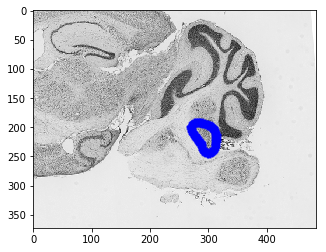

In [11]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
# x_offset = -50
# y_offset = -11
structure = 'DC'+'_surround_200um_noclass'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Negative Patches:',len(valid_patch_indices)

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (float(x)) )
    y_raw.append( (float(y)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')

plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

Number of Negative Patches: 1788
(8449, 10217, 5933, 8041)
uint8
(1788, 1788)
uint8
(2143, 1803)


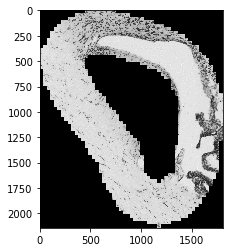

In [34]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
offset = 34
structure = 'DC'+'_surround_200um_noclass'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Negative Patches:',len(valid_patch_indices)

[left, right, up, down] = [int(min(all_locs[valid_patch_indices][:,0])), int(max(all_locs[valid_patch_indices][:,0])), \
                           int(min(all_locs[valid_patch_indices][:,1])), int(max(all_locs[valid_patch_indices][:,1]))]

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (int(x-left)) )
    y_raw.append( (int(y-up)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )
    
print(left, right, up, down)
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
print(img.dtype)
mask = np.zeros((down-up+1+offset, right-left+1+offset))
print(len(x_raw),len(y_raw))
for i in range(len(all_locs[valid_patch_indices])):
    mask[y_raw[i]:y_raw[i]+offset,x_raw[i]:x_raw[i]+offset]=1
mask=mask.astype(np.uint8)
print(mask.dtype)
patch = img[up:down+1+offset,left:right+1+offset]*mask#[0:down-up+1,0:right-left+1]
print(patch.shape)
#plt.figure( figsize=(50,50) )
plt.imshow( patch, cmap='gray')
#plt.imshow(mask, cmap='gray')

#plt.scatter(x_raw, y_raw, s=1, c='blue', alpha=.5)

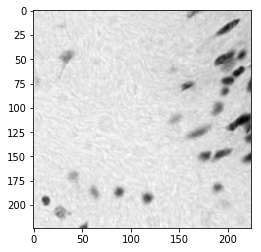

In [85]:
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
index = 20
x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset*32
y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset*32

patch = img[y:y+224,x:x+224]


plt.imshow( patch, cmap='gray')

In [86]:
# x_offset = -1600
# y_offset = -352
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        for index in range(len(all_patch_locations[structure][section])):
            x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset
            y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset
            patch = img[y:y+224,x:x+224]
            filename=savepath+'/'+str(section)+'_'+str(index)+'.tif'
            cv2.imwrite(filename, patch)


mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_patches: File exists
mkdir: /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain//CSHL_patches/MD589: File exists
7N_surround_200um_noclass ALREADY EXIST


In [ ]:
%pwd

In [ ]:
%cd $ROOT_DIR/CSHL_patches/$stack

In [ ]:
%ls 

In [ ]:
from glob import glob
for dir in glob('*'):
    print dir